In [75]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

<h3>APC Model</h3>
The APC model predicts responses of V4 cells to a set of shapes with respect to the curvature and angular position of diagnostic elements of their boundaries.
The angular position and curvature (APC) of each boundary element can be thought of as a point in the APC plane. Responses of a unit, $r$, are predicted by the product of $n=2$ Gaussians:

$$\large r = \max_p \left[ k \prod_{i=1}^n e^{\frac{-(X_{ip}-\mu_i)^2}{2 \zeta_i^2}} \right]$$

* $p$ is the number of points in the plane, i.e. number of parameterized boundary elements for a shape
* $X_{ip}$ is the value of the $i^{th}$ stimuli dimension (here we only use two, angular position and curvature), for the $p^{th}$ point (boundary element).
* $\mu_i$ is the mean of the $i^{th}$ gaussian along the $i^{th}$ stimuli dimension. 
* $\zeta_i$ is the gaussians standard deviation.
* $k$ is the amplitude of response of these guassians

For this case with $n=2$ our model has 5 free parameters:
the curvature gaussian $\mu_c, \zeta_c$,  the orientation gaussian $\mu_o, \zeta_o$, and $k$ which scaled responses. 

In the original paper these parameters were fit using a gradient descent method, the Gauss-Newton algorithm, with a grid of starting points across the APC plane. 

We instead discretely sampled parameter space taking the cartesian product of 16 values of $\mu_c, \zeta_c,   \mu_o, \zeta_o$, means were linearly spaced, and guassian were logarithmically spaced, end-points were the range of fits seen for V4 cells when fit by Gauss-Newton. $k$ was fit simply using least squares.

We measured the fit of each model to each unit, and took the best fit with respect $R^2$. We found this to be more rapid, and only performed slightly worse than the Gauss-Newton fits.

<h3>Stimuli</h3>
We adopted the approach of Pasupathy and Connor who used a set of 51 systematically designed simple closed shapes presented at different rotations to study the responses of isolated V4 neurons.

The original boundaries, were scaled then rasterized to fit within the theoretical receptive field of the second layer, maximumn extent 32 pixels. Typically inputs to AlexNet will have the grand mean of the 14 million training images substracted. In our case we did not do this, as this would introduce power outside of the presented shapes, which would confound interpretation of responses to shapes. Thus within the shapes, pixel values were set to the maximal available, 255, and outside pixel values were set to 0. We compare responses to natural images and find we are still able to drive all layers with these stimuli (see below).

For ease of comparison between the responses of different layers, we used the same scale for each layer, where the stimuli's total extent was less than 32 pixels. We also used 64 pixels to test whether changing the size made a signifcant difference in our results for later layers, (see below).


Pasupathy A, Connor CE (2001) Shape representation in area V4: position-specific tuning for boundary conformation. J Neurophys 86:2505-2519. [http://jn.physiology.org/cgi/ content/abstract/86/5/2505]

In [2]:
import os, sys
import numpy as np
top_dir = os.getcwd().split('v4cnn')[0]
sys.path.append(top_dir+ 'v4cnn/')
sys.path.append( top_dir + 'xarray');top_dir = top_dir + 'v4cnn/';
sys.path.append( top_dir + 'common/')
sys.path.append(top_dir +'/nets')
import matplotlib
from matplotlib.ticker import FuncFormatter
import pickle as pk
import xarray as xr;import pandas as pd
import apc_model_fit as ac
import matplotlib.ticker as mtick;
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import d_plot as dp
import scipy.io as  l
import d_curve as dc
import d_img_process as imp
%matplotlib inline  

In [3]:
fn = 'bvlc_reference_caffenetAPC362_pix_width[30.0]_pos_(64.0, 164.0, 101)_analysis.p'
try:
    an=pk.load(open(top_dir + 'data/an_results/' + fn,'rb'), 
               encoding='latin1')
except:
    an=pk.load(open(top_dir + 'data/an_results/' + fn,'rb'))
    
fvx = an[0].sel(concat_dim='r2')
rf = an[0].sel(concat_dim='rf')
cnn = an[1]
v4_name = 'V4_362PC2001'
v4_resp_apc = xr.open_dataset(top_dir + 'data/responses/' + v4_name + '.nc')['resp'].load()
v4_resp_apc = v4_resp_apc.transpose('shapes', 'unit')

/Users/deanpospisil/Desktop/modules/v4cnn/common/d_img_process.py:329: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  transformed_boundary = shape_boundary[imgDict['shapes'][ind]]


max: 255.0 min:0.0
max: 255.0 min:0.0


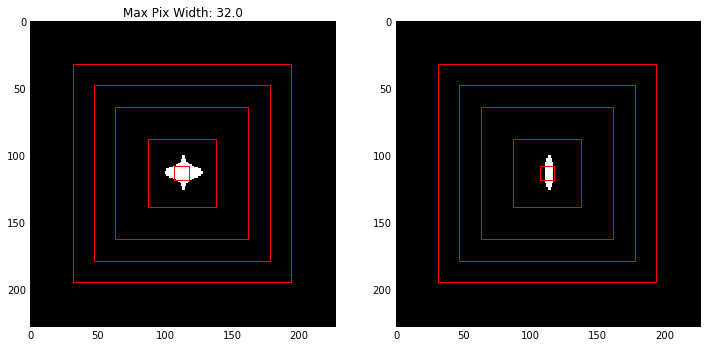

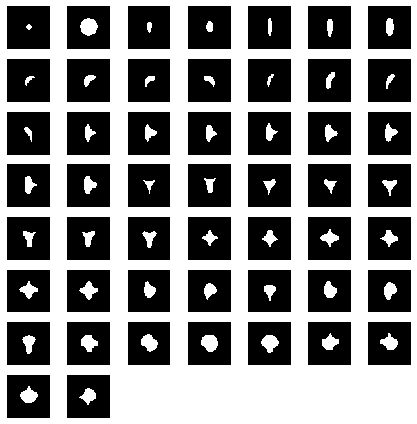

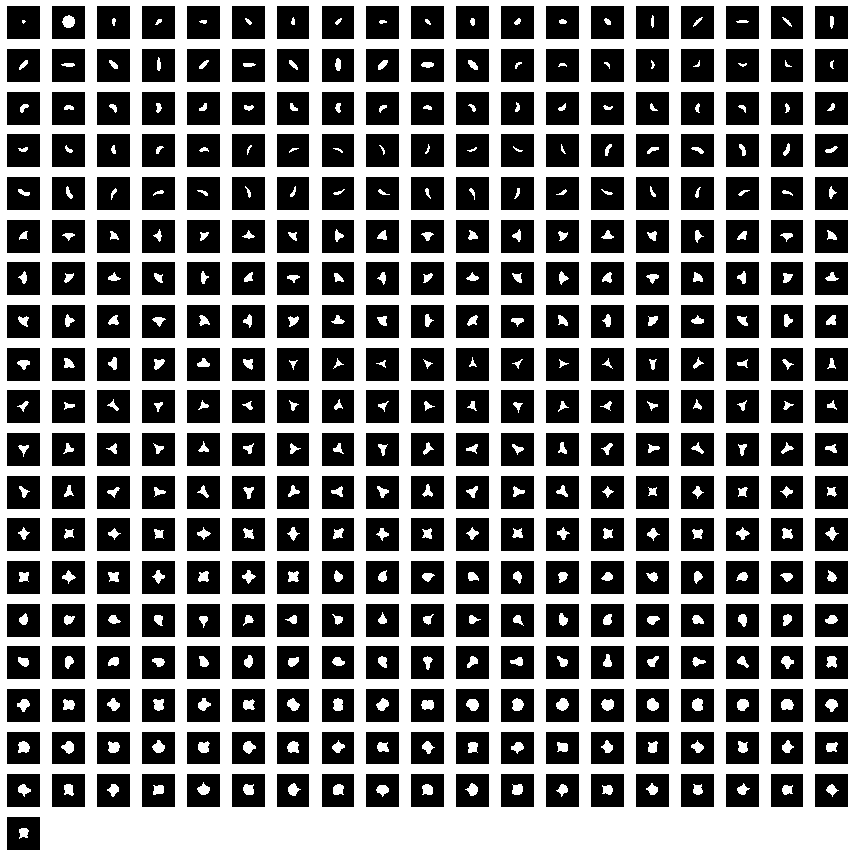

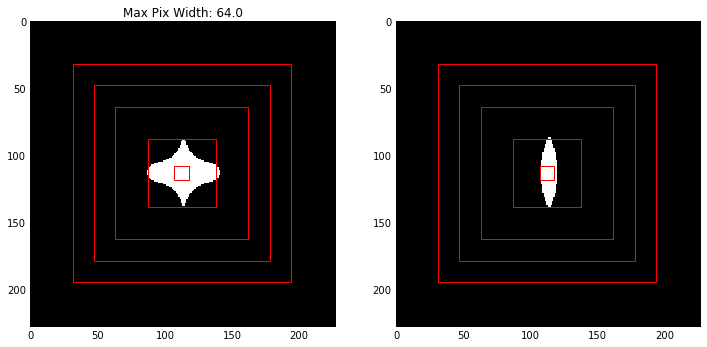

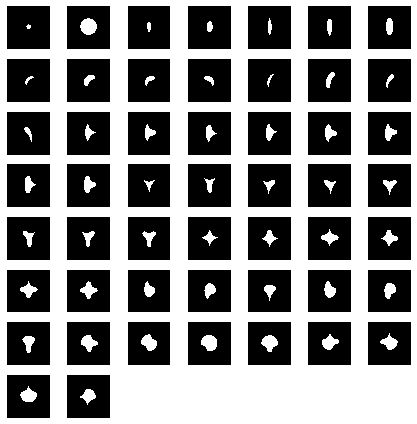

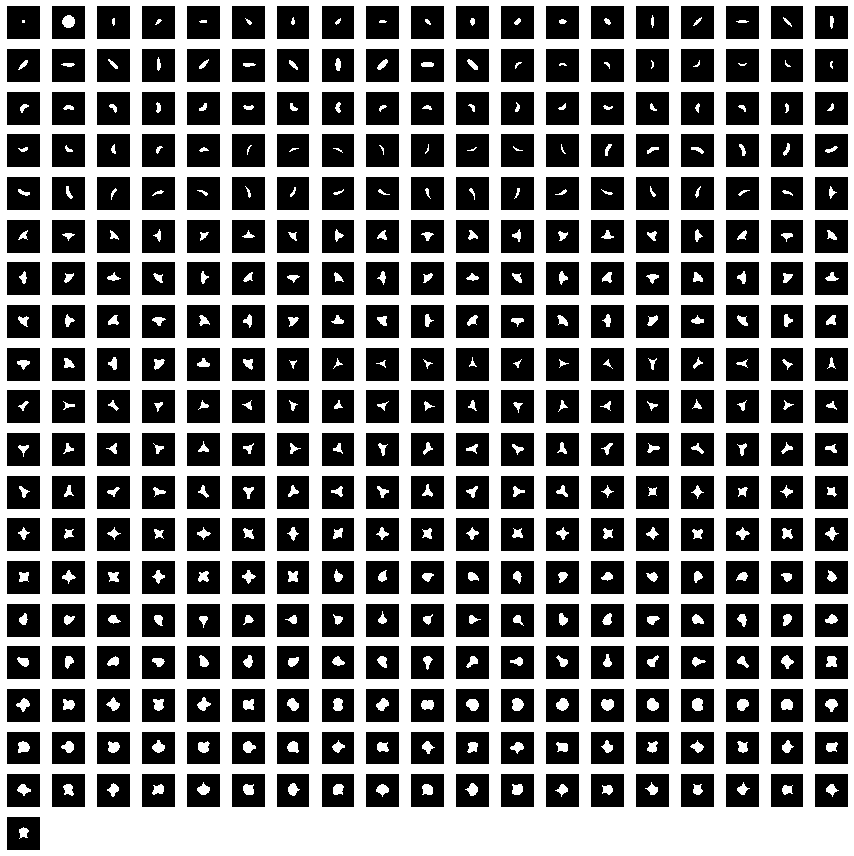

In [74]:
box_lengths = [11,51,99,131,163]#taking from wyeths CaffeNet figure
img_n_pix = 227
max_pix_width = [32.,]
for max_pix_width in [[32.,], [64.,]]:
    s = l.loadmat(top_dir + 'img_gen/PC3702001ShapeVerts.mat')['shapes'][0]
    base_stack = dc.center_boundary(s)
    boundaries = imp.center_boundary(s)
    scale = max_pix_width/dc.biggest_x_y_diff(boundaries)
    shape_ids = range(-1, 370); center_image = round(img_n_pix/2)
    x = (center_image, center_image, 1);y = (center_image, center_image, 1)
    stim_trans_cart_dict, stim_trans_dict = cf.stim_trans_generator(shapes=shape_ids, scale=scale, x=x, y=y)
    plt.figure(figsize=(12,24));
    center = 113

    trans_img_stack = np.array(imp.boundary_stack_transform(stim_trans_cart_dict, base_stack, npixels=227))
    #plot smallest and largest shape
    no_blank_image = trans_img_stack[1:]
    extents = (no_blank_image.sum(1)>0).sum(1)
    plt.subplot(121)
    
    plt.imshow(no_blank_image[np.argmax(extents)],
                              interpolation = 'nearest', cmap=plt.cm.Greys_r)
    plt.title('Max Pix Width: ' + str(max_pix_width[0]))
    for box_length in box_lengths:
        rectangle = plt.Rectangle((center-np.ceil(box_length/2.), center-np.ceil(box_length/2)),
                                   box_length, box_length, fill=False, edgecolor='r')
        plt.gca().add_patch(rectangle)
    plt.subplot(122)
    plt.imshow(no_blank_image[np.argmin(extents)],
                              interpolation = 'nearest', cmap=plt.cm.Greys_r)
    for box_length in box_lengths:
        rectangle = plt.Rectangle((center-np.ceil(box_length/2.), center-np.ceil(box_length/2)),
                                   box_length, box_length, fill=False, edgecolor='r')
        plt.gca().add_patch(rectangle)

    a = np.hstack((range(14), range(18,318)));a = np.hstack((a, range(322, 370)))
    no_blank_image = no_blank_image[a]
    aperture = max_pix_width[0]
    plt.figure(figsize=(6,6))
    no_rotation = [0, 1, 2, 10,14, 18, 26,30, 38, 46, 54, 62, 70, 78, 86, 94,102, 110, 118, 126, 134,
     142, 150, 158,166, 174, 182, 190,198, 206, 214, 222, 224, 232, 236, 244, 252, 254, 
     262, 270, 278, 286, 294, 302, 310, 314, 322, 330, 338, 346, 354, ]
    for i, a_shape in enumerate(no_blank_image[no_rotation]):
        plt.subplot(8,7,i+1)
        plt.imshow(a_shape, interpolation = 'nearest', cmap=plt.cm.Greys_r)
        plt.xlim([center-aperture, center+aperture]);plt.ylim([center-aperture, center+aperture])
        plt.xticks([]);plt.yticks([])
    plt.tight_layout()


    plt.figure(figsize=(12,12))
    for i, a_shape in enumerate(no_blank_image):
        plt.subplot(20,19,i+1)
        plt.imshow(a_shape, interpolation = 'nearest', cmap=plt.cm.Greys_r)
        plt.xlim([center-aperture, center+aperture]);plt.ylim([center-aperture, center+aperture])
        plt.xticks([]);plt.yticks([])
    plt.tight_layout()

    print('max: '+str(np.max(no_blank_image))
                + ' min:' + str(np.min(no_blank_image))) 
    

<h3>Sparsity.</h3>
We observed responses of CaffeNet both to our stimuli could be quite limited. Many units in the rectified layers of CaffeNet did not respond to any stimuli at any position or only several. Typical fits of the APC model predict rich tuning across shapes. In addition very sparse responses pose  a problem for our measure of translation invariance where if the unit only responds to one shape, then it trivially achieves perfect translation invariance. For these reasons we sought a measure of sparsity along which to filter for units with the range of sparsity seen for real V4 cells.
We considered a few different metrics of sparsity

A first choice was the coefficient of variation:
$$C = \frac{\sigma}{\mu}$$

and the variant made by Treves and Rolls that scales it between 0 and 1:

$$T = \frac{1}{C^2 + 1}$$

These were well suited to rectified layers of CaffeNet but for other layers such as FC8 where there were negative values did not work, as the measure was designed for positive distributions.

We also considered the Gini Coefficient but it suffered from the same problem.

We settled on kurtosis:

$$K = \frac{(x-\mu)^4}{n \sigma^4}$$

For a gaussian distribution $K=3$.

E T Rolls, M J Tovee, 1995, Sparseness of the neuronal representation of stimuli in the primate temporal visual cortex, Journal of Neurophysiology, 73(2):713-726.
D J Field, 1994, What is the goal of sensory coding?, Neural Computation, 6:559-601.

In [5]:
def kurtosis_unit(unit):
    mu = np.mean(unit)
    sig = np.std(unit)
    k = (np.sum(((unit - mu)**4)))/((sig**4)*len(unit))
    return k
def kurtosis(da):
    da = da.transpose('shapes', 'unit')
    mu = da.mean('shapes')
    sig = da.reduce(np.nanvar, dim='shapes')
    k = (((da - mu)**4).sum('shapes', skipna=True) / da.shapes.shape[0])/(sig**2)
    return k

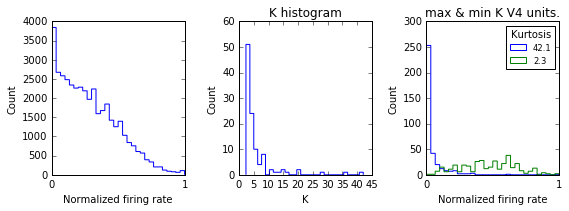

In [6]:
k_apc = kurtosis(v4_resp_apc).values

plt.figure(figsize=(8,3))
plt.subplot(131)
plt.hist(v4_resp_apc.values.ravel(),bins=30,histtype='step')
plt.xlabel('Normalized firing rate');plt.ylabel('Count');plt.xticks([0,1])

plt.subplot(132)
plt.hist(k_apc, bins=30, histtype='step')
plt.xlabel('K');plt.ylabel('Count');plt.title('K histogram')

plt.subplot(133)
plt.hist(v4_resp_apc[:, np.argmax(k_apc)], bins=30, log=False, normed=False, histtype='step',  range=[0,1])
plt.hist(v4_resp_apc[:, np.argmin(k_apc)], bins=30,log=False, normed=False, histtype='step', range=[0,1])
plt.legend(np.round([np.max(k_apc), np.min(k_apc)],1), 
           title='Kurtosis', loc=1, fontsize='small')
plt.xlabel('Normalized firing rate');plt.ylabel('Count');plt.xticks([0,1])

plt.title('max & min K V4 units.')
plt.tight_layout();plt.show();

From left to right. 
1. Here we see the data is normalized to one with a tendency towards lower values. 
2. We find our k-distribution is sparse with most units having a low k, but a few particularly sparse ones.
3. Plotting the response distribution of the units with highest and lowest k gives us a sense for what k measures, and the range of distributions.

sparsest possible = 369.002702703
max sparsity = 369.018615723


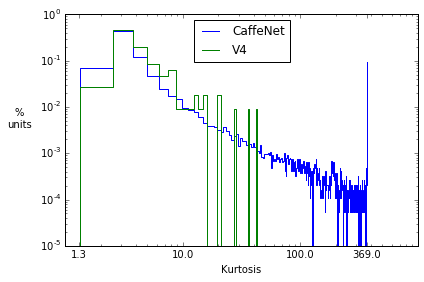

In [7]:
k_cnn = cnn['k'].dropna()

hist, bins = np.histogram(k_cnn.values, bins=300, normed=False)
hist =  hist/float(len(k_cnn))
hist = [0,] + list(hist)
plt.step(bins, hist)

hist, bins = np.histogram(k_apc, bins=bins, normed=False)
hist =  hist/float(len(k_apc))
hist = [0,] + list(hist)
plt.step(bins, hist)

plt.xscale('log', nonposy='clip');
plt.yscale('log', nonposy='clip');

yticks = np.round(np.array([np.min(hist), np.max(hist) , 1]),1)
#plt.yticks(yticks, yticks)
xticks= np.round(np.array([np.min(k_cnn), 10, 100, np.max(k_cnn)]),1)
plt.xticks(xticks, xticks);
plt.xlabel('Kurtosis');
plt.ylabel('%\nunits', rotation='horizontal', labelpad=20)
plt.tight_layout();
plt.legend(['CaffeNet','V4'], loc=9);



sparsest_unit = np.zeros((371,1))
sparsest_unit[0] = 1
k = kurtosis_unit(sparsest_unit)
print('sparsest possible = '+ str(k))
print('max sparsity = ' + str(max(k_cnn)))

CaffeNet has a clear peak near the highest possible kurtosis value. These are units that practically only responded to one shape. Clearly there are a fair amount of units with far higher kurtosis than those found in V4 for this shape set.

42.0708901143


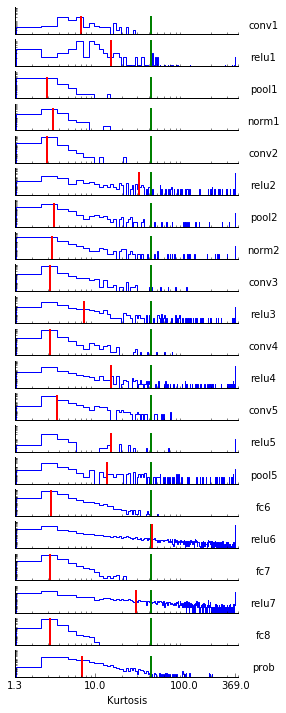

In [8]:
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

    
plt.figure(figsize=(4, 12))
title = 'Sparsity of Layers.'

cnn = k_cnn
layers = cnn.index.get_level_values('layer_label').unique()

n_subplot = len(layers)
for i, layer in enumerate(layers):
    plt.subplot(n_subplot, 1, i+1)
    vals = cnn.loc[layer].dropna().values.flatten()
    hist, bins = np.histogram(vals, bins=bins, normed=False)
    hist =  hist/float(len(vals))
    hist = [0,] + list(hist)
    plt.step(bins, hist)
    plt.xlim(min(cnn),400)

    plt.gca().set_ylabel(layer, ha='right', rotation=0, labelpad=25)
    plt.gca().yaxis.set_label_position("right")
    plt.xscale('log', nonposy='clip');
    plt.yscale('log', nonposy='clip');
    xticks = np.round(np.array([np.min(k_cnn), np.max(k_cnn)]),1)
    plt.xticks(xticks, xticks);
    plt.plot([max(k_apc),]*2,[0,max(hist)], lw=2, color='green')
    plt.plot([np.median(vals),]*2,[0,max(hist)], lw=2, color='red')
    simpleaxis(plt.gca())
dp.nice_axes(plt.gcf().axes)


#plt.xscale('log', nonposy='clip');
xticks= np.round(np.array([np.min(k_cnn),10,100, np.max(k_cnn)]),1)
plt.xticks(xticks, xticks, fontsize=10);
#plt.ylabel('%\nunits', rotation='horizontal', labelpad=20)

plt.xlabel('Kurtosis')
print(max(k_apc))

In blue we have the log-log histogram of kurtosis values in each layer, in red the median value, and in green the max kurtosis found in V4. 
Looking at the components of our grand histogram we see that it is the rectified layers primarily contributing to sparsity. The peak in the same spot for all of them, this being the maximal sparsity. By applying our threshold we bias our analyses towards units in the un-rectified layers.

In [9]:
print('Fraction cnn units greater then V4 max kurtosis: '+ 
      str(np.round(np.sum(np.max(k_apc)<k_cnn.values)/(len(k_cnn.values)),2)))

Fraction cnn units greater then V4 max kurtosis: 0.17


<h3>APC fit.</h3>
The angular position and curvature (APC) model was built to describe the responses of V4-cells to 52 unique shapes, and their rotations totaling 362 unique images. 
In our case we discretise the fitting to $ {16}^{4}$ potential models. Assuming the model is relatively smooth in its parameters we can get a sense for how well this discretization, approximates a fit over the continous space by examining the minimal correlations for neighboring points in the 4-d model space. TODO

In [10]:
fn = top_dir + 'data/models/' + 'apc_models_362.nc'
dmod = xr.open_dataset(fn, chunks={'models':50, 'shapes':370})['resp'].load()

In [11]:
apc_fit_v4 = ac.cor_resp_to_model(v4_resp_apc.chunk({'shapes': 370}), 
                                  dmod.chunk({}), 
                                  fit_over_dims=None, 
                                  prov_commit=False)
apc_fit_v4 = apc_fit_v4**2

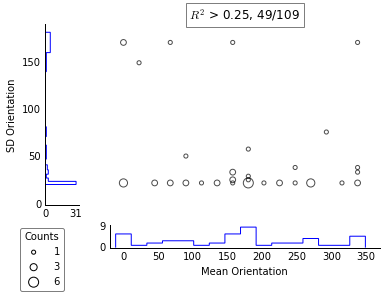

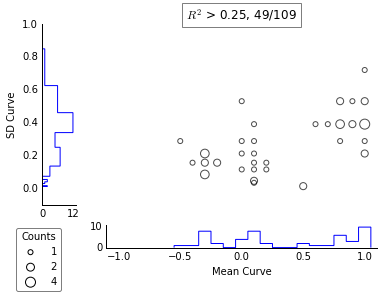

In [12]:
import imp as importmod
importmod.reload(dp)
import d_plot as dp
ybins_cur = dp.correct_bins_for_hist(np.unique(dmod.coords['cur_sd']))
xbins_cur = dp.correct_bins_for_hist(np.unique(dmod.coords['cur_mean']))
ybins_or = dp.correct_bins_for_hist(np.unique(dmod.coords['or_sd'].values/(2*np.pi))*360)
xbins_or = dp.correct_bins_for_hist((((np.unique(dmod.coords['or_mean'].values)/(2*np.pi))*360)%360))

rthresh = 0.25
#the_fits = [apc_fit_v4, apc_fit_cnn]
the_fits = [apc_fit_v4, ]
i=1
for apc_fit in the_fits:
    thresh_fits = apc_fit[apc_fit>rthresh]
    tot = len(apc_fit.values)
    ncell = len(thresh_fits['unit'])
    title = '$R^2$ > ' + str(rthresh) + ', ' + str(ncell) + '/' + str(tot)

    thresh_fits.coords['or_mean'] = ((thresh_fits.coords['or_mean']/(2*np.pi))*360)%360
    thresh_fits.coords['or_sd'] = ((thresh_fits.coords['or_sd']/(2*np.pi))*360)
    fig = dp.scatter_w_marginals(thresh_fits.coords['or_mean'].values, 
                                 thresh_fits.coords['or_sd'].values,
                        'Mean Orientation', 'SD Orientation',
                        xlim= [-20, 370],
                        #ylim= [0, np.round(np.max(threshFits['or_sd'] )+1,-1)],
                        ylim = [0, 190],
                        title = title,
                        ybins=ybins_or,
                        xbins=xbins_or)
    fig = dp.scatter_w_marginals(thresh_fits.coords['cur_mean'].values, 
                                 thresh_fits.coords['cur_sd'].values,
                        'Mean Curve', 'SD Curve',
                        xlim= [-1.1, 1.1],
                        ylim= [-0.1, np.round(np.max(thresh_fits['cur_sd']),0).values],
                        title = title,
                        ybins=ybins_cur,
                        xbins=xbins_cur)
#    fig = dp.scatter_w_marginals(thresh_fits.coords['cur_mean'].values, 
#                             thresh_fits.coords['or_sd'].values,
#                            'Mean Curve', 'SD Orientation',
#                            xlim= [-1.1, 1.1],
#                            ylim= [0, 190],
#                            title = title,
#                            ybins=ybins_or,
#                            xbins=xbins_cur)

1. For orientation preference, most cells have a tight preference for one orientation, i.e. they are not rotation invariant.
2. We can see for the V4 cells there are mainly three groups, those looking for mild convexities or concavities, and those looking for sharp points. Those looking for sharp point tends to have a larger SD for curvature, whereas those looking for concavities or convexities have a smaller amount perhaps sensitive to changes between negative or positive curvature.

/Users/deanpospisil/Desktop/modules/v4cnn/common/d_img_process.py:163: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  cImg = img[top:bottom, left:right]


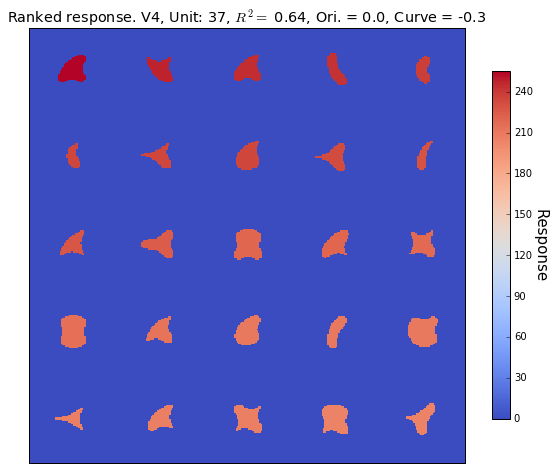

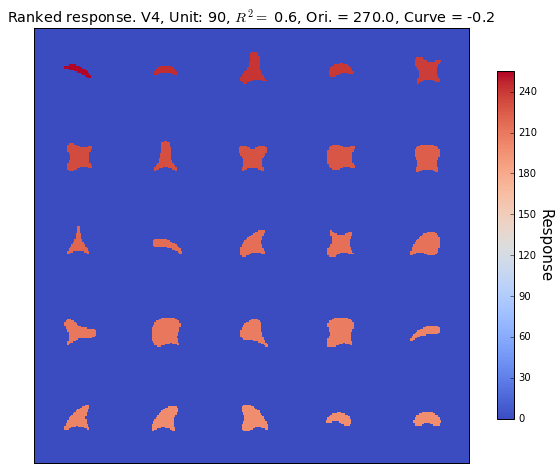

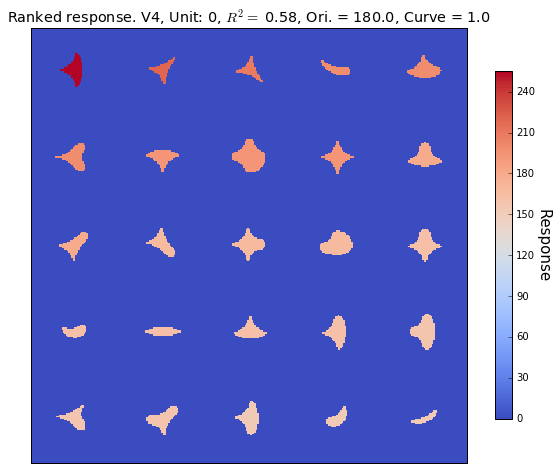

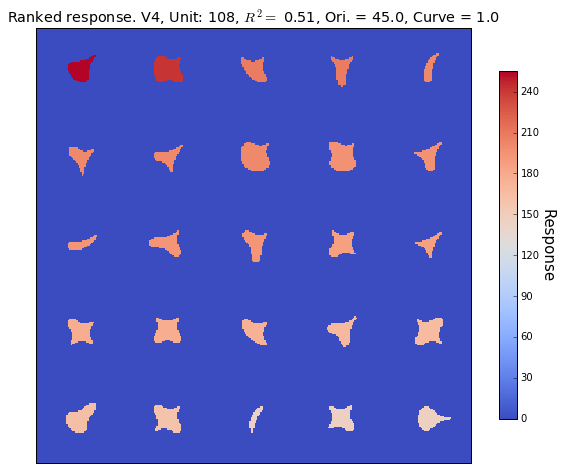

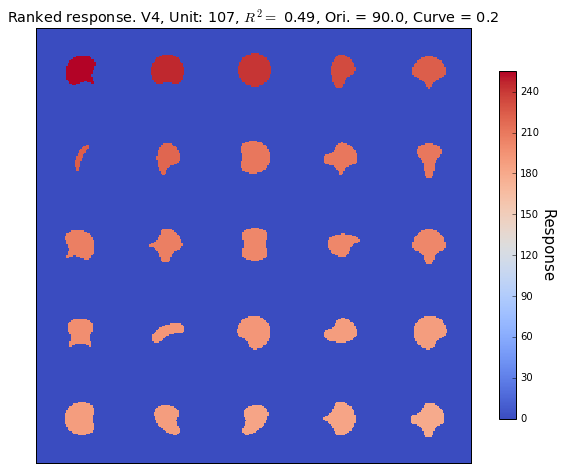

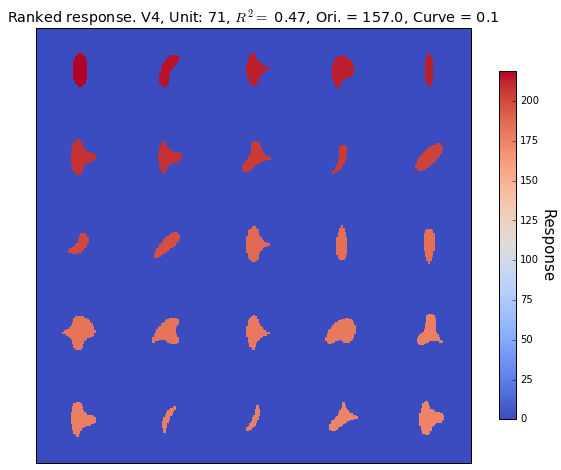

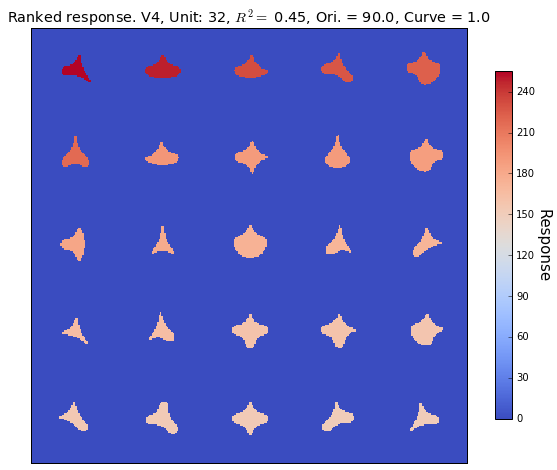

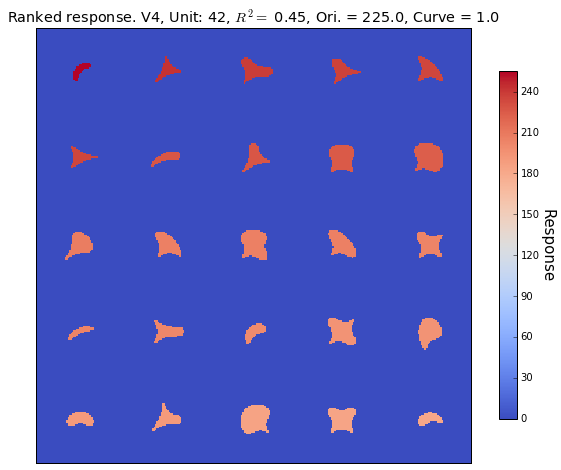

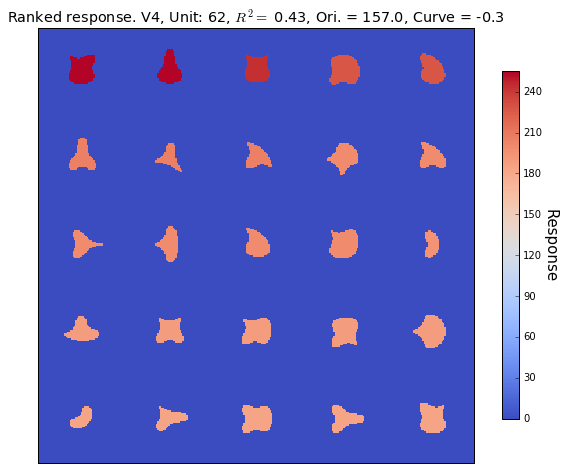

In [13]:
def vis_square(data, padsize=0, padval=0):
    
    plt.figure(figsize = (10,7.8))
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))

    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    plt.xticks([]);plt.yticks([])
    if min((data.ravel())>=0):
        clim = (min(abs(data.ravel())), max(abs(data.ravel())))
    else:
        clim = (-max(abs(data.ravel())), max(abs(data.ravel())))

    plt.imshow(data, interpolation='nearest', cmap=cm.coolwarm, clim=clim)
    cbar=plt.colorbar(shrink=0.8)
    cbar.ax.set_ylabel('Response', rotation= 270, labelpad=15, fontsize = 15,)
#    cbar.ax.yaxis.set_ticks([0,.25,.5,.75, 1])
#    cbar.ax.set_yticklabels(['0', .25, .5, .75, 1])
    cbar.solids.set_rasterized(True)
    #plt.tight_layout()
    #plt.show()
    return data
def plot_resp_on_shapes(imgStack, resp, image_square = 19):
    resp_sc = (resp.values*0.8 +.2)
    imgStack = imgStack*resp_sc.reshape(362,1,1)
    #sort images
    sortStack = imgStack[list(reversed(np.argsort(resp_sc))),:,:]
    sortStack = np.array([imp.centeredCrop(img, 64, 64) for img in sortStack])
    data = vis_square(sortStack[0:image_square**2])
    return data
for rank in range(1,10):
    best_unit = apc_fit_v4[apc_fit_v4.argsort().values[-rank]].squeeze()
    #print(best_unit)
    resp = v4_resp_apc.sel(unit=best_unit.coords['unit'].values)
    description = ('V4, Unit: ' +  str(resp.coords['unit'].values) + 
                   ', $R^2=$ ' + str(np.round(best_unit.values,2)) +
                   ', Ori. = ' + str(np.round(np.rad2deg(best_unit.or_mean.values)))+
                   ', Curve = ' + str(np.round(best_unit.cur_mean.values,2))) 
    _=plot_resp_on_shapes(no_blank_image, resp, image_square=5)
    plt.title('Ranked response. ' + description, fontsize='x-large')

Clearly we are not getting perfect fits even though qualitatively the cells really do prefer certain shapes at certain orientations. Lets plot our residuals and see if perhaps the errors are coming from lower responses predicted by the model.

In [76]:
best_mods_pd = dmod[:, apc_fit_v4[apc_fit_v4.argsort().values]
                  .squeeze().coords['unit'].models.values]
v4_resp_apc_pd = v4_resp_apc[:,apc_fit_v4.argsort().values].to_pandas()


fit_best_mods_pd = []
for resp, mod in zip(best_mods_pd.values.T, v4_resp_apc_pd.values.T):
    mod = np.expand_dims(mod, 1)
    resp = np.expand_dims(resp, 1)
    fit_best_mods_pd.append(np.dot(mod, np.linalg.lstsq(mod, resp)[0]))
fit_best_mods_pd = np.array(fit_best_mods_pd).squeeze().T
fit_best_mods_pd = pd.DataFrame(fit_best_mods_pd, columns=np.round(np.sort(apc_fit_v4.values),3))




In [17]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt 
import numpy as np
from itertools import product

def naked_plot(axes):
    for ax in  axes:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        
def fit_axis(ax, x, y, x_ax=True, y_ax=True, unity_ax=False):
    maxest = max([max(x), max(y)])
    minest = min([min(x), min(y)])
    if unity_ax:
        ax.plot([minest,maxest],[minest,maxest], lw=0.1, color='k');
    if min(y)<0:
        ax.plot([min(x),max(x)],[0,0], lw=.3, color='k');
    if min(x)<0:
        ax.plot([0,0],[min(y),max(y)], lw=.3, color='k');

def simple_hist(ax, var, orientation='vertical', fontsize=10):
    n = ax.hist(var,histtype='step', align='mid',lw=0.5, 
                bins=50, orientation=orientation)[0]
    naked_plot([ax,])
    the_range = [min(var), max(var)]
    if orientation[0]=='v':  
        ax.set_ylim(0, max(n)+max(n)*.15)
        
        ax.set_xlim(the_range)
        ax.text(np.max(var), 0, np.round(np.max(var),2),  ha='right',va='top', fontsize=fontsize )
        ax.text(np.min(var), 0, np.round(np.min(var),2),  ha='left',va='top', fontsize=fontsize)
        spine_loc = 'bottom'
    else:
        ax.set_xlim(0, max(n)+max(n)*.15)
        ax.set_ylim(the_range)
        ax.text(0, np.max(var), np.round(np.max(var),2),  ha='right',va='top', fontsize=fontsize )
        ax.text(0, np.min(var), np.round(np.min(var),2),  ha='right',va='bottom', fontsize=fontsize)
        spine_loc = 'left'
    ax.spines[spine_loc].set_visible(True)
    ax.spines[spine_loc].set(lw=0.5)
    ax.spines[spine_loc].set_bounds(the_range[0], the_range[1])
    
def small_mult_scatter_w_marg(x, y):
    m = y.shape[1]+1
    n = x.shape[1]+1
    left_bottom = m*n-n
    y_hist_pos = list(range(0, m*n, n))[:-1]
    x_hist_pos = list(range(left_bottom+1, m*n))
    
    scatter_inds = list(set(range(m*n)) - (set(x_hist_pos) | set(y_hist_pos) | set([left_bottom,])))
    cart_inds = list(product(range(m-1), range(n-1)))
    
    gs = gridspec.GridSpec(m, n,                    
                            width_ratios=[1,]+[8,]*(n-1),
                            height_ratios=[8,]*(m-1)+[1,]
                           )
    
    plt.figure(figsize=(n*2,m*2))
    fontsize=10
    y_hists = []
    for y_var, pos in zip(y.T, y_hist_pos):
        _=plt.subplot(gs[pos])
        simple_hist(_, y_var, orientation='horizontal')
        _.set_ylabel(str(pos), rotation='horizontal', 
                     labelpad=fontsize*3, fontsize=fontsize)
        y_hists.append(_)
    x_hists = []
    
    for x_var, pos in zip(x.T, x_hist_pos):
        _ = plt.subplot(gs[pos])
        simple_hist(_, x_var)
        _.set_xlabel(str(pos), rotation='horizontal', 
                      fontsize=fontsize)
        x_hists.append(_)
    
    scatters = []    
    for (y_ind, x_ind), pos in zip(cart_inds, scatter_inds):
        _ = plt.subplot(gs[pos], sharex= x_hists[x_ind], sharey=y_hists[y_ind])
        _.scatter(x[:, x_ind], y[:, y_ind], s=0.1)
        fit_axis(_, x[:, x_ind], y[:, y_ind])
        scatters.append(_)
        
    
    naked_plot(scatters)
    return scatters, x_hists, y_hists

    
fit_units -= np.mean(fit_units,1, keepdims=1)
lsq_models = np.array([model*np.linalg.lstsq(
             np.expand_dims(model,1),np.expand_dims(unit,1))[0] 
             for unit, model in zip(fit_units, fit_models)])
for ind in range(1,10):
    x = np.expand_dims(lsq_models[-ind].ravel(),1)
    y = np.expand_dims(fit_units[-ind].ravel(),1)
    y = np.concatenate([y,x-y],1)

    scatters, x_hists, y_hists = small_mult_scatter_w_marg(x, y)
    y_labels = ['Unit', 'Residuals']
    
    best_unit = apc_fit_v4[apc_fit_v4.argsort().values[-rank]].squeeze()
    the_unit = v4_resp_apc.sel(unit=best_unit.coords['unit'].values)
    
#    description = ('V4, Unit: ' +  str(the_unit.coords['unit'].values) + 
#                   ', $R^2=$ ' + str(np.round(the_unit.values,2))+
#                   ', Ori. = ' + str(np.round(np.rad2deg(the_unit.or_mean.values))) +
#                   ', Curve = ' + str(np.round(the_unit.cur_mean.values,2)))
#    scatters[0].set_title(description)
    [hist.set_ylabel(label) for label, hist in zip(y_labels, y_hists)]
    x_labels = ['Model',]
    [hist.set_xlabel(label) for label, hist in zip(x_labels, x_hists)]


NameError: name 'fit_models' is not defined

We can see a lower triangular pattern with the 10 best fit units, 